# Workshop 3:  pandas, netCDF, xarray

# Part II: netCDF files and basic xarray

In climate science we often find ourselves with __gridded (array) data__, often in up to 4 dimensions: (latitude, longitude, height/depth/pressure, time). This can be model output, but also observed data. These datasets can be huge, for example, the monthly output of the high resolution Community Earth System Model is some 50 GB and that is for the ocean only!

Apart from the data, e.g. temperatures, we also need to keep track of their locations and record other kinds of metadata. netCDF can store all of this information in a single, standardized file.

Below we quote from the [NetCDF website](https://www.unidata.ucar.edu/software/netcdf/docs/faq.html#whatisit):

>NetCDF (network Common Data Form) is a set of interfaces for array-oriented data access and a freely distributed collection of data access libraries for C, Fortran, C++, Java, and other languages. The netCDF libraries support a machine-independent format for representing scientific data. Together, the interfaces, libraries, and format support the creation, access, and sharing of scientific data.
>
>NetCDF data is:
>
> - Self-Describing. A netCDF file includes information about the data it contains.
> - Portable. A netCDF file can be accessed by computers with different ways of storing integers, characters, and floating-point numbers.
> - Scalable. A small subset of a large dataset may be accessed efficiently.
> - Appendable. Data may be appended to a properly structured netCDF file without copying the dataset or redefining its structure.
> - Sharable. One writer and multiple readers may simultaneously access the same netCDF file.
> - Archivable. Access to all earlier forms of netCDF data will be supported by current and future versions of the software.

Xarray was designed to make reading netCDF files in python as easy, powerful, and flexible as possible. (See [xarray netCDF docs](http://xarray.pydata.org/en/latest/io.html#netcdf) for more details.)

This tutorial is adapted in large part from the [xarray FAQ](http://xarray.pydata.org/en/stable/faq) and the [Earth and Environmental Data Science course's xarray lecture](https://earth-env-data-science.github.io/lectures/xarray/xarray.html).

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### xarray Terminology

First we need to establish the basic concepts. Imagine ocean model output with temperature and salinity stored at (x,y,z,t).

Similar to pandas, there are two data structures available in xarray:
- `DataArray`: is single variable field, e.g. temperature that can be high dimensional at each point for several time steps.
- `Dataset`: holds several DataArrays, e.g. both the temperature and salinity fields. These DataArrays may be aligned, i.e. be located at the same points.

A `DataArray` has four essential attributes:
* `values`: a `numpy.ndarray` holding the array’s values, e.g. temperature or salinity values
* `dims`: dimension names for each axis (e.g., `('x', 'y', 'z')`, or `('lat', 'lon', 'time')`)
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings), e.g. the locations in a spatial direction: 1 m, 2 m, 3 m, ... or in time: day 1, day 2, day 3, ...
* `attrs`: an `OrderedDict` to hold arbitrary metadata (attributes)

In [2]:
da = xr.DataArray(np.random.randn(2, 3), dims=("x", "y"), coords={"x": [10, 20]})
da  # this produces a fancy html representation of the data

<xarray.DataArray (x: 2, y: 3)>
array([[-0.34207516, -0.30078222, -0.12032055],
       [ 1.5250163 ,  0.88666331,  0.1672857 ]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

We have generated a 2D array, assigned the names x and y to the two dimensions respectively and associated two coordinate labels ‘10’ and ‘20’ with the two locations along the x dimension. Notice not every dimension need the have a coordinate.

These are the key properties of the DataArray:

In [3]:
print(da.values)
print(da.dims)
print(da.coords)
print(da.attrs)  # empty

[[-0.34207516 -0.30078222 -0.12032055]
 [ 1.5250163   0.88666331  0.1672857 ]]
('x', 'y')
Coordinates:
  * x        (x) int64 10 20
{}


Xarray has built-in plotting, like pandas.

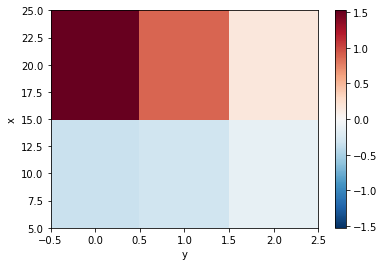

In [4]:
da.plot()  # notice the automatic labeling

### indexing

In [5]:
# positional and by integer label, like numpy
print(da[0, :], '\n\n')

# loc or "location": positional and coordinate label, like pandas
print(da.loc[10], '\n\n')

# isel or "integer select":  by dimension name and integer label
print(da.isel(x=0), '\n\n')

# sel or "select": by dimension name and coordinate label
print(da.sel(x=10), '\n\n')

# the values do not need to be exact
# this is extremely handy for selecting the closest location, for example
print(da.sel(x=12, method='nearest'), '\n\n')

<xarray.DataArray (y: 3)>
array([-0.34207516, -0.30078222, -0.12032055])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 


<xarray.DataArray (y: 3)>
array([-0.34207516, -0.30078222, -0.12032055])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 


<xarray.DataArray (y: 3)>
array([-0.34207516, -0.30078222, -0.12032055])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 


<xarray.DataArray (y: 3)>
array([-0.34207516, -0.30078222, -0.12032055])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 


<xarray.DataArray (y: 3)>
array([-0.34207516, -0.30078222, -0.12032055])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 




Unlike positional indexing, label-based indexing frees us from having to know how our array is organized. All we need to know are the dimension name and the label we wish to index i.e. data.sel(x=10) works regardless of whether x is the first or second dimension of the array and regardless of whether 10 is the first or second element of x. We have already told xarray that x is the first dimension when we created data: xarray keeps track of this so we don’t have to.

### open netCDf files
Opening netCDF files is a simple command with xarray.

Let us first download some the NASA [GISSTemp](https://data.giss.nasa.gov/gistemp/) global temperature anomaly dataset. If you cannot downlowad it with the code below, go to the website and download (and unzip) `gistemp1200_ERSSTv5.nc.gz` manually: https://data.giss.nasa.gov/pub/gistemp/

In [6]:
# by prepending an exclamation mark, you can execute shell commands
! wget https://data.giss.nasa.gov/pub/gistemp/gistemp1200_ERSSTv5.nc.gz
! gunzip gistemp1200_ERSSTv5.nc.gz

zsh:1: command not found: wget
gunzip: can't stat: gistemp1200_ERSSTv5.nc.gz (gistemp1200_ERSSTv5.nc.gz.gz): No such file or directory


In [7]:
ds = xr.open_dataset('data/gistemp1200_GHCNv4_ERSSTv5.nc')

### inspect content of netCDF files

In [8]:
ds

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, nv: 2, time: 1688)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2020-08-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] ...
    tempanomaly  (time, lat, lon) float32 ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2020-09-11 17:20:54 by SBBX_to_nc 2.0 - ILAND=1200,...

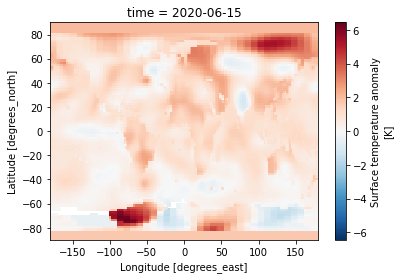

In [9]:
ds.tempanomaly.sel(time='2020-06-01', method='nearest').plot()

We can create a Dataset in [several ways](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html), here is one using a distionary with names and DataArrays:

### Datasets

A Dataset holds many DataArrays which potentially can share coordinates. In analogy to pandas:

    pandas.Series : pandas.Dataframe :: xarray.DataArray : xarray.Dataset
    
Constructing Datasets manually is a bit more involved in terms of syntax. The Dataset constructor takes three arguments:

* `data_vars` should be a dictionary with each key as the name of the variable and each value as one of:
  * A `DataArray` or Variable
  * A tuple of the form `(dims, data[, attrs])`, which is converted into arguments for Variable
  * A pandas object, which is converted into a `DataArray`
  * A 1D array or list, which is interpreted as values for a one dimensional coordinate variable along the same dimension as it’s name
* `coords` should be a dictionary of the same form as data_vars.
* `attrs` should be a dictionary.

In [10]:
# a simplified way to construct a dataset is to provide a dictionry with the names and DataArrays:
xr.Dataset({'data':da, 'data_squared':da**2})

<xarray.Dataset>
Dimensions:       (x: 2, y: 3)
Coordinates:
  * x             (x) int64 10 20
Dimensions without coordinates: y
Data variables:
    data          (x, y) float64 -0.3421 -0.3008 -0.1203 1.525 0.8867 0.1673
    data_squared  (x, y) float64 0.117 0.09047 0.01448 2.326 0.7862 0.02798

### plotting netCDF data
We saw above that xarray has some built in plotting, we can modify these plots with extra matplotlib code.

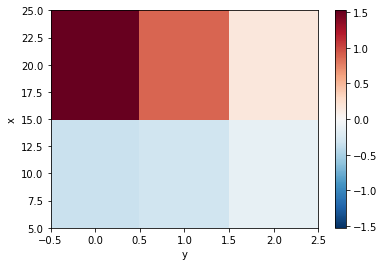

In [11]:
da.plot()

Text(0.5, 0, 'some other x label')

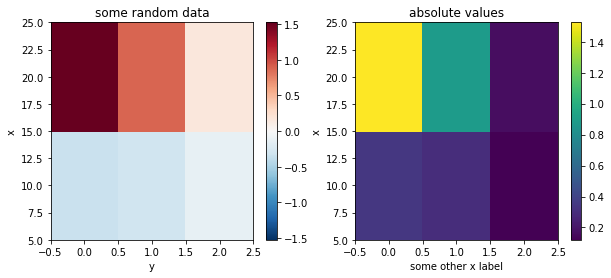

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
da.plot(ax=ax[0])
ax[0].set_title('some random data')
abs(da).plot(ax=ax[1])
ax[1].set_title('absolute values')
ax[1].set_xlabel('some other x label')

### creating netCDF files and saving them
Above we created the DataArray `da` which we can save with a singlke command as a netcdf file (this also works for DataSets):

In [13]:
da.to_netcdf('test.nc')

### Other data formats
Although netCDF is the de-facto standard in climate science, you may encounter other data formats:
##### GRIB
##### ZARR
##### HDF
##### binary
Most of these can be opened with xarray, others you may need to combine into a DataSet/DataArray object yourself.

### Other netCDF packages and software

[netCDF4-python](https://github.com/Unidata/netcdf4-python) provides a lower level interface for working with netCDF and OpenDAP datasets in Python. netCDF4-python is used internally in xarray.

[Iris](http://scitools.org.uk/iris/) (supported by the UK Met office) provides similar tools for in- memory manipulation of labeled arrays, aimed specifically at weather and climate data needs. Indeed, the Iris Cube was direct inspiration for xarray’s DataArray. xarray and Iris take very different approaches to handling metadata: Iris strictly interprets CF ('Climate and Forecast') conventions. Iris particularly shines at mapping, thanks to its integration with Cartopy.

[UV-CDAT](http://uvcdat.llnl.gov/) is another Python library that implements in-memory netCDF-like variables and tools for working with climate data.

[Panoply](https://www.giss.nasa.gov/tools/panoply/) is a netCDF, HDF and GRIB data viewer.

## <span style="color:blue">Exercises</span>

1. Create a dataset with two (10x10x10) DataArrays `A` and `B` with dimensions `lat`, `lon`, `time` and some sensible coordinates. Use `pd.date_range` function to create time coordinates (use the `pd.date_range?` to find out how to use it). Create a `source` attribute that mentions who created the Dataset. Save the dataset as `test2.nc`.

2. Select the time series of temperature anomalies of you birth place (with the latitude and longitude) from the GISSTEMP dataset `ds` that we briefly inspected before.  Use the `resample(time='A').mean()` to create annual means.  Calculate the temperature mean between 1970 and 2000 and use it as a reference. Create the iconic warming stripes graphic. Use [this tutorial](https://matplotlib.org/matplotblog/posts/warming-stripes/) as an inspiration.
<img src="figures/3b2.png" width="800">

## <span style="color:green">Solutions</span>

In [14]:
# 1. Create a dataset with two (10x10x10) DataArrays `A` and `B` 
# with dimensions `lat`, `lon`, `time` and some sensible coordinates.
# Use the `pd.date_range` function to create time coordinates 
# (use the `pd.date_range?` to find out how to use it).
# Create a `source` attribute that mentions who created the Dataset.
# Save the dataset as `test2.nc`.

nlat, nlon, ntime = 10, 10, 10
lats = np.linspace(-90, 90, nlat)
lons = np.linspace(0, 360, nlon)
times = pd.date_range(start='2020-01-01', end='2020-09-28', periods=ntime)
data_A = np.random.rand(nlat, nlon, ntime)
data_B = np.random.rand(nlat, nlon, ntime)
ds_ = xr.Dataset(data_vars={'A':(('lat','lon','time'), data_A),
                           'B':(('lat','lon','time'), data_B),
                          },
                coords={'lat':lats, 'lon':lons, 'time':times}
               )
ds_.attrs['source'] = 'created by André Jüling'
print(ds_)
ds_.to_netcdf('test2.nc')

<xarray.Dataset>
Dimensions:  (lat: 10, lon: 10, time: 10)
Coordinates:
  * lat      (lat) float64 -90.0 -70.0 -50.0 -30.0 -10.0 ... 30.0 50.0 70.0 90.0
  * lon      (lon) float64 0.0 40.0 80.0 120.0 160.0 ... 240.0 280.0 320.0 360.0
  * time     (time) datetime64[ns] 2020-01-01 2020-01-31T02:40:00 ... 2020-09-28
Data variables:
    A        (lat, lon, time) float64 0.1993 0.5018 0.4105 ... 0.6578 0.412
    B        (lat, lon, time) float64 0.9485 0.7548 0.1256 ... 0.3446 0.6504
Attributes:
    source:   created by André Jüling


<xarray.DataArray 'tempanomaly' ()>
array(0.39822218, dtype=float32)
Coordinates:
    lat      float32 51.0
    lon      float32 13.0


/Users/Andre/miniconda3/envs/teach/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


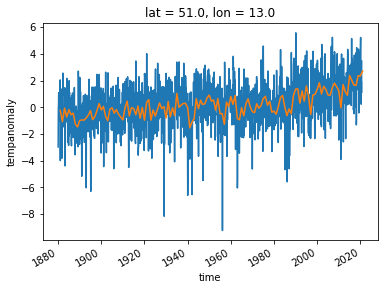

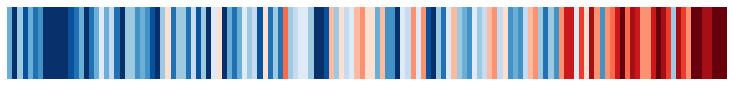

In [15]:
# 2. Select the time series of temperature anomalies of you birth place 
# from the GISSTEMP dataset `ds` that we briefly inspected before.
# Use the `resample(time='A').mean()` to create annual means.
# Calculate the temperature mean between 1970 and 2000 and use it as a reference.
# Create the iconic warming stripes graphic.
# Use this tutorial as an inspiration: https://matplotlib.org/matplotblog/posts/warming-stripes/
timeseries = ds.tempanomaly.sel({'lat':51.343479, 'lon':12.387772}, method='nearest')
reference = timeseries.sel({'time':slice('1970-01-01','2000-01-01')}).mean()
print(reference)
annual = timeseries.resample(time='A').mean()
timeseries.plot()
annual.plot()

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

fig = plt.figure(figsize=(10, 1))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
col = PatchCollection([Rectangle((y, 0), 1, 1) for y in range(1880, 2020 + 1)])
col.set_array(annual.values)
col.set_cmap(cmap)
col.set_clim(reference-1.5, reference+1.5)
ax.add_collection(col)
ax.set_ylim(0, 1)
ax.set_xlim(1880,2020+1)
plt.savefig('figures/3b2')